# Discontinuity detection

## Discontinuities on audio
Discontinuities are generally produced by hardware or software issues in the process of recording or copying audio data.
Typically the recording device fails to capture a small segment of audio.
Depending on the relative positions of the samples before and after the missing segment, the discontinuity can be noticeable or not.

## Generating synthetic discontinuities
Let's start by degrading an audio file with some discontinuities.
This is simulated by removing an arbitrary number of contiguous samples from the audio.
For this example, we will make sure that the discontinuities are noticeable.

In [1]:
from IPython.display import Audio

from essentia.standard import MonoLoader, DiscontinuityDetector, FrameGenerator
from essentia import array
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] =(12, 9)

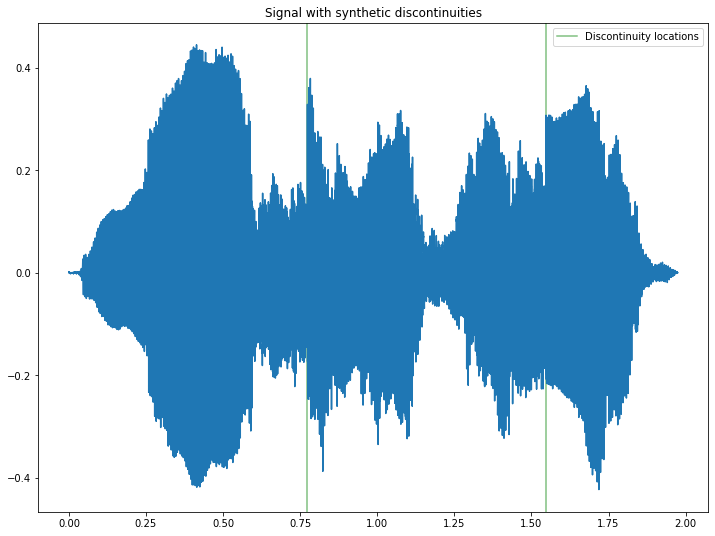

In [2]:
sr = 44100

audio_file = '../../../test/audio/recorded/vignesh.wav'
audio = MonoLoader(filename=audio_file)()

jump_starts = np.array([len(audio) // 4, len(audio) // 2])
ground_truth = jump_starts / sr

for start in jump_starts:
    l_amp = audio[start]
    # Remove samples until the jump produces a prominent discontinuity so it can be perceived.
    end = next(
    idx for idx, r_amp in enumerate(audio[start:], start) if abs(r_amp - l_amp) > 0.3
)
    audio = np.delete(audio, range(start, end))

for point in ground_truth:
    l1 = plt.axvline(point, color='g', alpha=.5)

time_index = np.arange(len(audio)) / sr
plt.plot(time_index, audio)
plt.title('Signal with synthetic discontinuities')
l1.set_label('Discontinuity locations')
plt.legend()

Let's listen to the degraded audio:

In [3]:
Audio(audio, rate=sr)

## Detecting the discontinuities

[DiscontinuityDetector](https://essentia.upf.edu/reference/std_DiscontinuityDetector.html) uses [LPC](https://en.wikipedia.org/wiki/Linear_predictive_coding) and some heuristics to detect discontinuities in the audio signal [1].
The algorithm returns the locations and amplitudes of the clicks on a frame-wise basis.

In [4]:
# Analysis parameters.
frame_size = 512
hop_size = 256

discontinuityDetector = DiscontinuityDetector(frameSize=frame_size, hopSize=hop_size)

locs = []
for idx, frame in enumerate(
    FrameGenerator(audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True)
):
    frame_locs, _ = discontinuityDetector(frame)
    locs.extend((frame_locs + hop_size * idx) / sr)

The following plot shows the detections and ground truth:

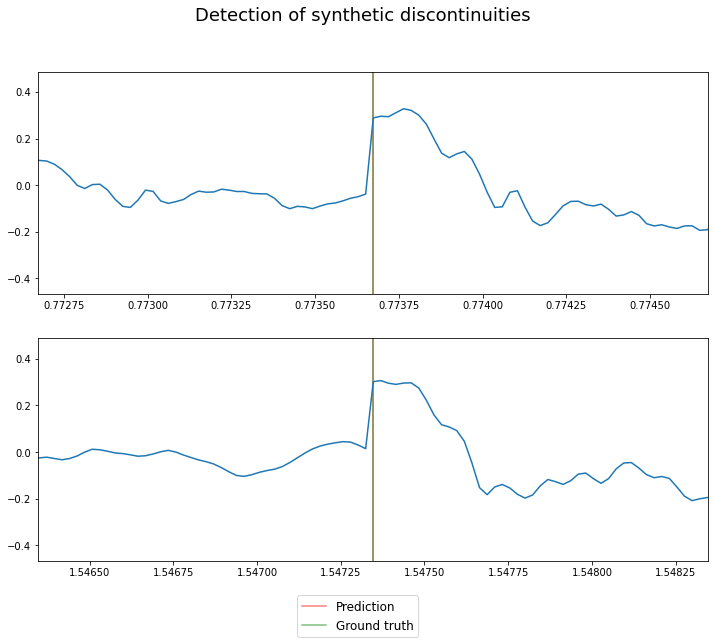

In [5]:
fig, ax = plt.subplots(len(ground_truth))

for idx, point in enumerate(ground_truth):
    l1 = ax[idx].axvline(locs[idx], color='r', alpha=.5)
    l2 = ax[idx].axvline(point, color='g', alpha=.5)
    ax[idx].plot(time_index, audio)
    ax[idx].set_xlim([point - .001, point + .001])

fig.suptitle('Detection of synthetic discontinuities', fontsize=18)
fig.legend(
    (l1, l2), ("Prediction", "Ground truth"), fontsize=12, loc="lower center"
)

## References
[1] Mühlbauer, R. (2010). Automatic Audio Defect Detection.